Partie 1: Mécanique céleste

In [4]:
import numpy as np
from astropy.constants import G, M_earth, M_sun 
import matplotlib.pyplot as plt
import de421
from astropy.time import Time
from jplephem import Ephemeris

5.972167867791379e+24


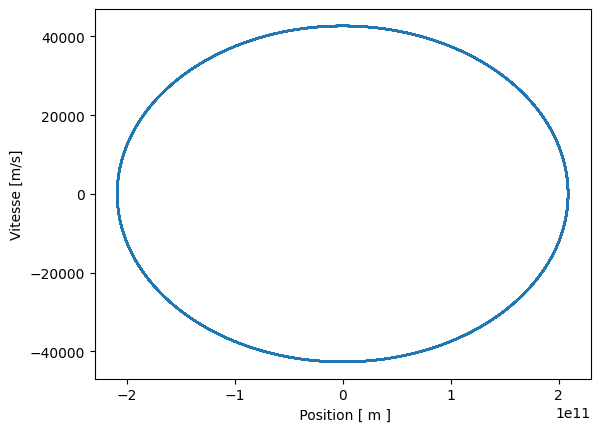

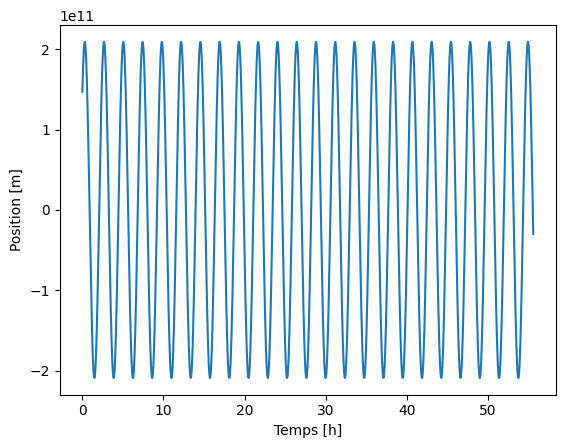

In [6]:
#a) Calcul de la méthode de Verlet
r_0 = 1.4710e11 # m
v_0 = 3.0287e4#m/s
print(M_earth.value)
def f(r):
    return(-G.value * M_sun.value * r/r_0**3)

def verlet(r_0, v_0, h, max):
    v_h = [v_0]
    r_h = [r_0]
    v_1 =  v_0 + 0.5 * h * f(r_0)
    r = r_0

    for i in range(1, max):
        r = r + h * v_1
        k = h * f(r)
        v_2 = v_1 + 0.5 * k 
        v_1 = v_1 + k
        v_h.append(v_2)
        r_h.append(r)
         

    return(v_h, r_h)

max = 200000
temps = [x/3600 for x in range(max)]
v_h, r_h = verlet(r_0, v_0, 3600, max)


plt.figure()
plt.plot(r_h, v_h)
plt.ylabel("Vitesse [m/s]")
plt.xlabel(" Position [ m ]")
plt.show()

plt.figure()
plt.plot(temps, r_h)
plt.ylabel("Position [m]")
plt.xlabel("Temps [h]")
plt.show()


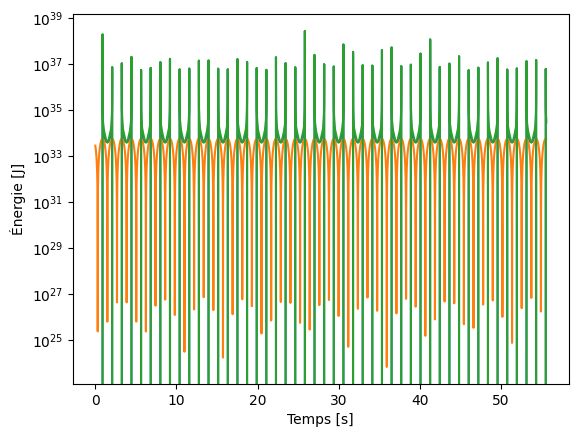

In [7]:
def verlet(r_0, v_0, h, max):
    v_h = [v_0]
    r_h = [r_0]
    U = [-G.value*M_sun.value*M_earth.value/r_0]
    E_k = [1/2*M_earth.value*v_0**2]
    E_tot = [U[0]+E_k[0]]
    
    v_1  =  v_0 + 0.5 * h * f(r_0)
    r = r_0

    for i in range(1, max):
        r = r + h * v_1
        if  abs(r) < 1000: 
            r = 1000
        k = h * f(r)
        v_2 = v_1 + 0.5 * k 
        v_1 = v_1 + k

        v_h.append(v_2)
        r_h.append(r)
 
        E_k.append(1/2*M_earth.value*v_2**2)
        U.append(-G.value*M_sun.value*M_earth.value/r)
        E_tot.append(U[i] + E_k[i])
    return(U, E_k, E_tot)


U, E_k, E_tot = verlet(r_0, v_0, 3600, max)


plt.figure()
plt.semilogy(temps,U)
plt.semilogy(temps, E_k)
plt.semilogy(temps, E_tot)
plt.ylabel("Énergie [J]")
plt.xlabel("Temps [s]")
plt.show()

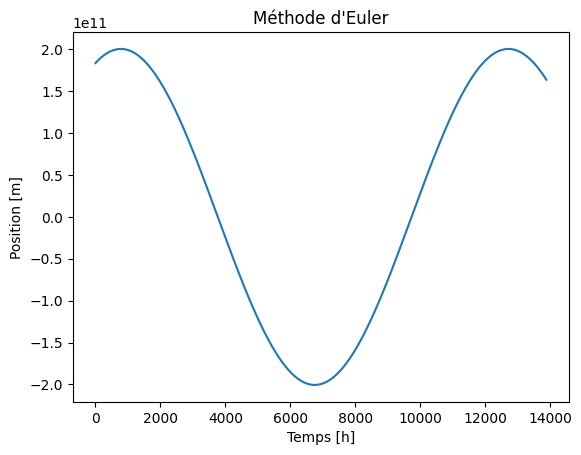

In [15]:
def Euler(a, b, h, r_0, v_0): 
    tpoints = np.arange(a,b,h)
    rpoints = []
    r = r_0 
    v = v_0
    for t in tpoints: 
        rpoints.append(r)
        v += h * f(r)
        r = r + h*v
    return(rpoints, tpoints)

rpoints,tpoints = Euler(0, 50000000, 3600, r_0, v_0)
temps = [x/3600 for x in tpoints]
plt.figure()
plt.title("Méthode d'Euler")
plt.ylabel("Position [m]")
plt.xlabel("Temps [h]")
plt.plot(temps,rpoints)
plt.show()


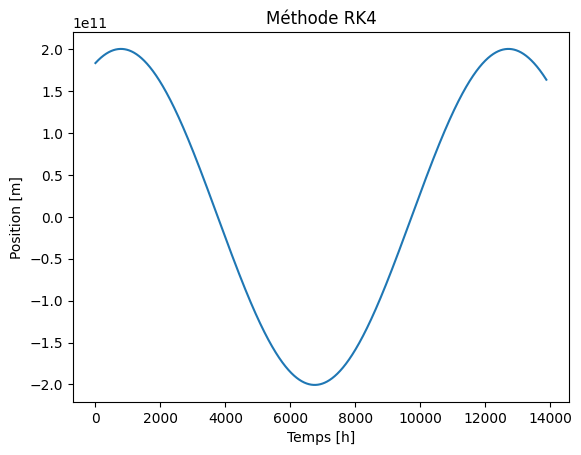

In [14]:
def RK2(a, b, h, r_0, v_0): 
    tpoints = np.arange(a,b,h)
    rpoints = []
    r = r_0 
    v = v_0
    for t in tpoints: 
        rpoints.append(r)
        k1 = h * f(r)
        k2 = h * f(r+0.5*k1)
        v += k2
        r = r + h*v
    return(rpoints, tpoints)

def RK4(a, b, h, r_0, v_0): 
    tpoints = np.arange(a,b,h)
    rpoints = []
    r = r_0 
    v = v_0
    for t in tpoints: 
        rpoints.append(r)
        k1 = h * f(r)
        k2 = h * f(r+0.5*k1)
        k3 = h*f(r+0.5*k2)
        k4 = h*f(r+k3)
        v += (k1+2*k2+2*k3+k4)/6
        r = r + h*v
    return(rpoints, tpoints)

rpoints,tpoints= RK4(0, 50000000, 3600, r_0, v_0)
temps = [x/3600 for x in tpoints]

plt.figure()
plt.title("Méthode RK4")
plt.ylabel("Position [m]")
plt.xlabel("Temps [h]")
plt.plot(temps,rpoints)
plt.show()

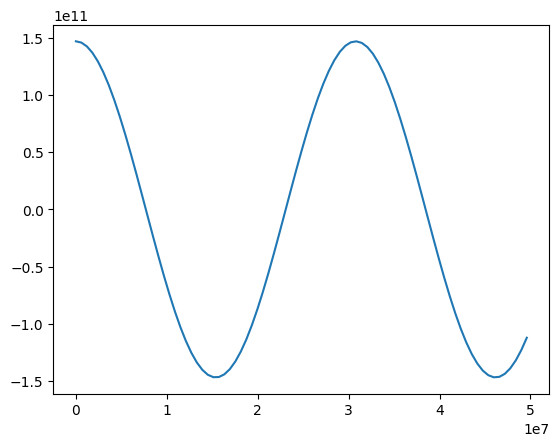

In [10]:
#d) Bulirsch-Stoer


def f(r):
    return((-G.value * M_sun.value * r/r_0**3)) 

def g(r):
    x = r[0]
    v = r[1]
    fx=v
    fv=f(x)
    return np.array([fx, fv],float)

def Bulirsch(a, b, H, r_0, v_0, delta):
    tpoints = np.arange(a, b, H)
    xpoints = []
    r = np.array([r_0, 0.0], float)
    
    for t in tpoints:
        xpoints.append(r[0])
        n = 1
        r1 = r+ 0.5*H*g(r)
        r2 = r + H*f(r1)

        R1 = np.empty([1,2],float)
        R1[0] = 0.5*(r1+r2+0.5*H*f(r2))

        error=2*H*delta
        while error > H*delta:
            n += 1
            h = H/n

            r1 = r + 0.5*h*g(r)
            r2 = r + h*g(r1)

            for i in range(n-1):
                r1 += h*g(r2)
                r2 += h*g(r1)
            R2 = R1
            R1 = np.empty([n,2], float)
            R1[0] = 0.5*(r1+r2+0.5*h*g(r2))

            for m in range (1, n):
                epsilon = (R1[m-1]-R2[m-1])/((n/(n-1))**(2*m)-1)
                R1[m] = R1[m-1] + epsilon 
            error = abs(epsilon[0])
        r = R1[n-1]              
    return(xpoints, tpoints)

r_0 = 1.4710e11 # m
v_0 = 3.0287e4#m/s


r, t = Bulirsch(0, 50000000, 3600*24*7, r_0, v_0, 1000/(365*24*3600))

plt.plot(t, r)
plt.show()

C:\Users\gaelm\AppData\Local\Temp\ipykernel_1572\4112036982.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  r_0 = float(position[0]*1000)
C:\Users\gaelm\AppData\Local\Temp\ipykernel_1572\4112036982.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  v_0 = float(velocity[0]/86.4)


183767020103.49557 11786.84795448745


C:\Users\gaelm\AppData\Local\Temp\ipykernel_1572\731024753.py:44: RuntimeWarning: overflow encountered in subtract
  epsilon = (R1[m-1]-R2[m-1])/((n/(n-1))**(2*m)-1)
C:\Users\gaelm\AppData\Local\Temp\ipykernel_1572\731024753.py:45: RuntimeWarning: overflow encountered in add
  R1[m] = R1[m-1] + epsilon
C:\Users\gaelm\AppData\Local\Temp\ipykernel_1572\731024753.py:44: RuntimeWarning: invalid value encountered in subtract
  epsilon = (R1[m-1]-R2[m-1])/((n/(n-1))**(2*m)-1)


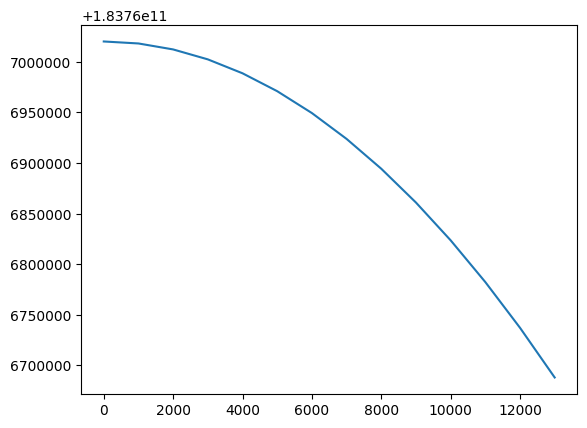

[-1.94538523e+09]
nan


In [16]:
eph = Ephemeris(de421)
# dates
lancement=Time("2020-07-30")
atterissage=Time("2021-02-18")
# un nombre de jours juliens est attendu par la routine, d’o`u le .jd
# position en km, vitesse en km par jour
position, velocity = eph.position_and_velocity('mars',lancement.jd)

r_0 = float(position[0]*1000)
v_0 = float(velocity[0]/86.4)

print(r_0, v_0)

def f(r):
    return((-G.value * M_sun.value * r/r_0**3)) 

def g(r):
    x = r[0]
    v = r[1]
    fx=v
    fv=f(x)
    return np.array([fx, fv],float)

r, t = Bulirsch(0, 203*24*60*60, 1000, r_0, v_0, 1000/(365*24*3600))

plt.plot(t, r)
plt.show()

position_fin = eph.position('mars',atterissage.jd)
print(position_fin[0]*1000)
print(r[-1])